In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import pandas as pd
from datetime import datetime
pd.options.display.max_columns = None
from pybaseball import batting_stats, pitching_stats, cache, playerid_lookup, statcast_batter, statcast_pitcher, statcast

cache.enable()
cache.config.cache_type='csv'
cache.config.save()

In [2]:
from sqlalchemy import MetaData, text, Column, Integer, String, ForeignKey, Table, create_engine, Float, Boolean, DateTime
from sqlalchemy.orm import relationship, backref, sessionmaker
from sqlalchemy.ext.declarative import declarative_base

meta = MetaData()
engine = create_engine('sqlite:///fantasy_data.db', echo=False)
Session = sessionmaker(bind=engine)
session = Session()
Base = declarative_base()

In [95]:
n_teams = 13
tm_players = 23
tm_dollars = 260
player_split = .6
pitcher_split = 1 - player_split
tot_dollars = n_teams * tm_dollars
tot_players = n_teams * tm_players
tot_hitters = n_teams * 14
tot_pitchers = n_teams * 9

drafted_by_pos = {
    'C':n_teams,
    '1B':round(n_teams*1.5),
    '2B':round(n_teams*1.5),
    '3B':math.floor(n_teams*1.5),
    'SS':math.floor(n_teams*1.5),
    'OF':n_teams*5,
    'MI':n_teams,
    'CI':n_teams,
    'DH':n_teams*2, 
    'P':n_teams*9,
    'SP':round(n_teams*6.5),
    'RP':math.floor(n_teams*2.5),
}

def load_data():
    atc = pd.read_csv('data/2022-atc-proj-h.csv', encoding="latin-1")
    dc = pd.read_csv('data/2022-dc-proj-h.csv', encoding="latin-1")
    steamer = pd.read_csv('data/2022-steamer-proj-h.csv', encoding="latin-1")
    zips = pd.read_csv('data/2022-zips-proj-h.csv', encoding="latin-1")
    val_h = pd.read_csv('data/2022-fangraphs-auction-calculator-h.csv')
    val_h.rename(columns={'PlayerId':'playerid', 'POS':'Pos'},inplace=True)
    cbs = pd.read_csv('data/2022-cbs-values.csv', encoding="latin-1")
    h = atc.append(dc).append(steamer).append(zips).sort_values('playerid')
    h = h.merge(val_h[['playerid', 'Pos', 'Dollars']]).merge(cbs[['playerid', 'CBS']], on='playerid', how='left')
    h.drop(columns=['wOBA', 'CS', 'Fld', 'BsR', 'ADP'],inplace=True)
    h['Primary_Pos'] = h.apply(lambda x: find_primary_pos(x['Pos']), axis=1)
    proj = pd.pivot_table(h, index='playerid', values=['G', 'PA', 'AB', 'H', 'HR', 'R', 'RBI', 'SB'], aggfunc='mean').merge(h[['playerid', 'Name', 'Team', 'Pos', 'Primary_Pos', 'Dollars', 'CBS']], on='playerid', how='inner').drop_duplicates()
    proj['sorter'] = proj['HR']+proj['R']+proj['RBI']+proj['H']+proj['SB']
    proj['BA'] = proj['H']/proj['AB']
    proj = proj.drop_duplicates(subset='playerid')

    atc = pd.read_csv('data/2022-atc-proj-p.csv', encoding="latin-1")
    dc = pd.read_csv('data/2022-dc-proj-p.csv', encoding="latin-1")
    steamer = pd.read_csv('data/2022-steamer-proj-p.csv', encoding="latin-1")
    zips = pd.read_csv('data/2022-zips-proj-p.csv', encoding="latin-1")
    val_p = pd.read_csv('data/2022-fangraphs-auction-calculator-p.csv')
    val_p.rename(columns={'PlayerId':'playerid', 'POS':'Pos'},inplace=True)
    p = atc.append(dc).append(steamer).append(zips).sort_values('playerid')
    p = p.merge(val_p[['playerid', 'Pos', 'Dollars']]).merge(cbs[['playerid', 'CBS']], on='playerid', how='left')
    p.rename(columns={'H':'HA'},inplace=True)
    p['Sv+Hld'] = p['SV']+p['HLD']
    p['Primary_Pos'] = p['Pos'].apply(lambda x: ', '.join(x.split('/')))

    pproj = pd.pivot_table(p, index='playerid', values=['GS', 'G', 'IP', 'ER', 'HA', 'SO', 'BB', 'W', 'SV', 'HLD', 'Sv+Hld'], aggfunc='mean').merge(p[['playerid', 'Name', 'Team', 'Pos', 'Dollars', 'CBS']], on='playerid', how='inner').drop_duplicates()
    pproj['sorter'] = pproj['SO']+(pproj['Sv+Hld']*4)+pproj['W']
    pproj['Primary_Pos'] = pproj.apply(lambda x: find_primary_pos(x['Pos']), axis=1)
    #proj = proj.append(pproj)
    pproj['IP'].fillna(0, inplace=True)
    for i in ['PA', 'AB', 'G', 'H', 'HR', 'R', 'RBI', 'SB']:
        proj[i].fillna(0,inplace=True)
        proj[i] = proj[i].apply(lambda x: int(x))
    for i in ['GS', 'G', 'HA', 'SO', 'ER', 'BB', 'W', 'SV', 'HLD', 'Sv+Hld']:
        pproj[i].fillna(0,inplace=True)
        pproj[i] = pproj[i].apply(lambda x: int(x))
    pproj['ERA'] = pproj['ER']/pproj['IP']*9
    pproj['WHIP'] = (pproj['HA']+pproj['BB'])/pproj['IP']
    pproj = pproj.drop_duplicates(subset='playerid')
    
    return proj.sort_values('Dollars', ascending=False), pproj.sort_values('Dollars', ascending=False)

def calc_z(x, stat):
    z = (x - drafted[stat].mean()) / drafted[stat].std()
    return z

def find_primary_pos(p):
    pos_list = p.split('/')
    pos_hierarchy = ['C', '3B', '2B', '1B', 'SS', 'OF', 'DH', 'SP', 'RP', 'P']
    for i in pos_hierarchy:
        if i in pos_list:
            return i

def owners(conv):
    df = pd.read_sql('players', engine)
    owners_df = df.groupby('Owner').agg({'Name':'count', 'Paid':'sum', 'z':'sum', 'H':'sum', 'AB':'sum', 'HR':'sum', 'R':'sum', 'RBI':'sum', 'SB':'sum', 'W':'sum', 'Sv+Hld':'sum', 'SO':'sum'}).reset_index()
    owners_df.rename(columns={'Name':'Drafted'},inplace=True)
    owners_df['$/unit'] = owners_df['Paid']/owners_df['z']
    owners_df['$ Left'] = tm_dollars - owners_df['Paid']
    owners_df['$ Left / Plyr'] = owners_df['$ Left'] / (tm_players -owners_df['Drafted'])
    owners_df['Cash Sitch'] = owners_df['$ Left / Plyr'] / (((tot_dollars - owners_df.Paid.sum()) + owners_df['Paid']) / ((tot_players - owners_df.Drafted.sum()) + owners_df['Drafted']))
    owners_df['Value'] = (owners_df['z']*conv)-owners_df['Paid']
    owners_df['BA'] = owners_df['H']/owners_df['AB']
    owners_df['Pts'] = 0
    for i in ['BA', 'HR', 'R', 'RBI', 'SB', 'W', 'Sv+Hld', 'SO']:
        owners_df['Pts'] += owners_df[i].rank()
    owners_df['Rank'] = owners_df['Pts'].rank()
    return df.sort_values('z', ascending=False), owners_df

def check_roster_pos(roster, name, team_name, pos, eligible):
    eligible_at = eligible.split('/')
    eligibility = []
    for p in eligible.split('/'):
        if p=='C':
            eligibility.extend(['C'])
        if p=='1B':
            eligibility.extend(['1B', 'CI'])
        if p=='2B':
            eligibility.extend(['2B', 'MI'])
        if p=='3B':
            eligibility.extend(['3B', 'CI'])
        if p=='SS':
            eligibility.extend(['SS', 'MI'])
        if p=='OF':
            eligibility.extend(['OF1', 'OF2', 'OF3', 'OF4', 'OF5'])
        if p in ['SP', 'RP']:
            eligibility.extend(['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9'])
        
    eligibility = list(dict.fromkeys(eligibility))
    if 'SP' in eligible_at or 'RP' in eligible_at: 
        pos_list = eligibility
    else:
        pos_list = eligibility+['DH1', 'DH2']
    for p in pos_list:
        if roster.loc[p, team_name]==0:
            roster.loc[p, team_name] = name
            return p
    
    return pos_list

def next_closest_in_tier(df, pos, playerid):
    try:
        i = df[(df['Primary_Pos']==pos) & (df['playerid']==playerid) & (df['Owner'].isna())].index[0]
        val = df[(df['Primary_Pos']==pos) & (df['Owner'].isna()) & (df['playerid']==playerid)]['Value'].iloc[0]
        return df[df['playerid']==playerid]['Value'].iloc[0] - df[(df['Primary_Pos']==pos) & (df['Owner'].isna()) & (df['Value']<=val)].iloc[1]['Value']
    except:
        return 0
    
def big_board(row, stat):
    # qual_avgs comes from 2019 and 2021 qualified players' averages and stdevs for each stat
    qual_avgs = {'G':[145.0, 10.8], 'PA':[600.4, 59.6], 'AB':[533.4, 53.6], 'H':[143.7, 22.5], 'HR':[24.4, 10.4], 'zlgBA':[0.20, 13.9],
            'R':[82.5, 17.6], 'RBI':[78.9, 19.9], 'SB':[8.6, 8.8], 'AVG':[.269, .026], 'W':[6.1, 4.3], 'GS':[7.6, 13.5], 'Sv+Hld':[12.9, 11.6],
            'ER':[37.3, 23.7], 'IP':[91.2, 53.2], 'SO':[95.7, 57.4], 'BB':[30.2, 15.7], 'HA':[79.7, 50.9], 'zlgERA':[.1235, 89.55], 'zlgWHIP':[-.1512, 17.63368]}
    if stat == 'BA':
        ba_pts = row['H']-(row['AB']*(qual_avgs['H'][0]/qual_avgs['AB'][0]))
        zBA = (ba_pts-qual_avgs['zlgBA'][0])/qual_avgs['zlgBA'][1]
        #return ((row['AB'] * (((row['H']/row['AB'])-qual_avgs['AVG'][0])/qual_avgs['AVG'][1])) - qual_avgs['zlgBA'][0])/qual_avgs['zlgBA'][1]
        return zBA
    elif stat=='ERA':
        pts = ((row['ER']*9) - ((row['IP']*qual_avgs['ER'][0]*9)/qual_avgs['IP'][0])) * -1
        zERA = (pts-qual_avgs['zlgERA'][0])/qual_avgs['zlgERA'][1]
        return zERA
    elif stat=='WHIP':
        pts = ((row['HA']+row['BB'])-(row['IP']*((qual_avgs['HA'][0]+qual_avgs['BB'][0])/qual_avgs['IP'][0]))) * -1
        zWHIP = (pts-qual_avgs['zlgWHIP'][0])/qual_avgs['zlgWHIP'][1]
        return zWHIP
    else:
        return (row[stat] - qual_avgs[stat][0]) / qual_avgs[stat][1]

In [96]:
h, p = load_data()

In [97]:
h['zR'] = h.apply(lambda row: big_board(row, 'R'), axis=1)
h['zHR'] = h.apply(lambda row: big_board(row, 'HR'), axis=1)
h['zRBI'] = h.apply(lambda row: big_board(row, 'RBI'), axis=1)
h['zSB'] = h.apply(lambda row: big_board(row, 'SB'), axis=1)
h['zBA'] = h.apply(lambda row: big_board(row, 'BA'), axis=1)
h['BIGAA'] = h['zR']+h['zRBI']+h['zHR']+h['zSB']+h['zBA']

p['zSO'] = p.apply(lambda row: big_board(row, 'SO'), axis=1)
p['zW'] = p.apply(lambda row: big_board(row, 'W'), axis=1)
p['zSv+Hld'] = p.apply(lambda row: big_board(row, 'Sv+Hld'), axis=1)
p['zERA'] = p.apply(lambda row: big_board(row, 'ERA'), axis=1)
p['zWHIP'] = p.apply(lambda row: big_board(row, 'WHIP'), axis=1)
p['BIGAA'] = p['zSv+Hld']+p['zSO']+p['zW']+p['zERA']+p['zWHIP']

print('Positional adjustment applied by primary position')
c_adjust = abs(h[h['Primary_Pos']=='C'].sort_values('BIGAA',ascending=False).iloc[drafted_by_pos['C']]['BIGAA'])
h.loc[h['Primary_Pos']=='C', 'Pos_adj'] = c_adjust
ci_adjust = abs(h[h['Primary_Pos'].isin(['1B', '3B'])].sort_values('BIGAA',ascending=False).iloc[drafted_by_pos['1B']+drafted_by_pos['3B']]['BIGAA'])
h.loc[h['Primary_Pos'].isin(['1B', '3B']), 'Pos_adj'] = ci_adjust
mi_adjust = abs(h[h['Primary_Pos'].isin(['2B', 'SS'])].sort_values('BIGAA',ascending=False).iloc[drafted_by_pos['SS']+drafted_by_pos['2B']]['BIGAA'])
h.loc[h['Primary_Pos'].isin(['2B', 'SS']), 'Pos_adj'] = mi_adjust
of_adjust = abs(h[h['Primary_Pos'].isin(['OF', 'DH'])].sort_values('BIGAA',ascending=False).iloc[drafted_by_pos['OF']]['BIGAA'])
h.loc[h['Primary_Pos'].isin(['OF', 'DH']), 'Pos_adj'] = of_adjust

print('C',h[h['Primary_Pos']=='C'].sort_values('BIGAA',ascending=False).iloc[drafted_by_pos['C']]['BIGAA'])
print('MI',h[h['Primary_Pos'].isin(['2B', 'SS'])].sort_values('BIGAA',ascending=False).iloc[drafted_by_pos['1B']+drafted_by_pos['3B']]['BIGAA'])
print('CI',h[h['Primary_Pos'].isin(['1B', '3B'])].sort_values('BIGAA',ascending=False).iloc[drafted_by_pos['SS']+drafted_by_pos['2B']]['BIGAA'])
print('OF',h[h['Primary_Pos'].isin(['OF', 'DH'])].sort_values('BIGAA',ascending=False).iloc[drafted_by_pos['OF']]['BIGAA'])

sp_adjust = abs(p[p['Primary_Pos']=='SP'].sort_values('BIGAA',ascending=False).iloc[drafted_by_pos['SP']]['BIGAA'])
p.loc[p['Primary_Pos']=='SP', 'Pos_adj'] = sp_adjust
rp_adjust = abs(p[p['Primary_Pos']=='RP'].sort_values('BIGAA',ascending=False).iloc[drafted_by_pos['RP']]['BIGAA'])
p.loc[p['Primary_Pos']=='RP', 'Pos_adj'] = rp_adjust
print('SP',p[p['Primary_Pos'].isin(['SP'])].sort_values('BIGAA',ascending=False).iloc[drafted_by_pos['SP']]['BIGAA'])
print('RP',p[p['Primary_Pos'].isin(['RP'])].sort_values('BIGAA',ascending=False).iloc[drafted_by_pos['RP']]['BIGAA'])

# Apply Positional adjustment
h['z'] = h['BIGAA'] + h['Pos_adj']
p['z'] = p['BIGAA'] + p['Pos_adj']

# Apply H/P split
# Commented out the split conversion because the dollar converter works this in by using total dollar / total z of both hitters and pitchers
#p['z'] = p['BIGAA']*(p[p['BIGAA']>0]['BIGAA'].sum()/(h[h['BIGAA']>0]['BIGAA'].sum()+p[p['BIGAA']>0]['BIGAA'].sum()))
#h['z'] = h['BIGAA']*(h[h['BIGAA']>0]['BIGAA'].sum()/(h[h['BIGAA']>0]['BIGAA'].sum()+p[p['BIGAA']>0]['BIGAA'].sum()))
#p['z'] = p['BIGAA']# * pitcher_split
#h['z'] = h['BIGAA']# * player_split

conv = (tm_dollars/tm_players)*(tot_players/(h[h['z']>0]['z'].sum()+p[p['z']>0]['z'].sum()))
print('\nTotal z:',h[h['z']>0]['z'].sum()+p[p['z']>0]['z'].sum())
print('\nH/P split:',h[h['z']>0]['z'].sum()/(h[h['z']>0]['z'].sum()+p[p['z']>0]['z'].sum()))
print('Conversion to $:',conv)

h['Value'] = h['z']*conv
p['Value'] = p['z']*conv

p.loc[p['Name']=='Shohei Ohtani', 'playerid'] = 'p19755'

b = h.append(p)
b['Outs'] = b['IP']*3
b['K/9'] = b['SO']*9/(b['Outs']/3)
b['Timestamp'] = None
b['Paid'] = 0
b['Owner'] = None
b['Used'] = None

Positional adjustment applied by primary position
C -6.153191339388657
MI -3.6228684092310233
CI -2.1155278202895724
OF -3.8751151846441028
SP -1.6972569973871898
RP -0.3461899290585227

Total z: 701.3944209397413

H/P split: 0.6579266945868755
Conversion to $: 4.818971892407433


In [ ]:
# Update data with Keepers
#b = b.drop(columns=['Paid', 'Timestamp', 'Owner']).merge(pd.DataFrame(keepers), on='playerid', how='left')
#b['Paid'].fillna(0,inplace=True)
#b["Paid"] = pd.to_numeric(b.Paid, downcast='integer')

In [137]:
# Uploads data to table
#b.set_index('playerid')[['Name', 'Team', 'Pos', 'Primary_Pos', 'G', 'GS', 'PA', 'AB', 'H', 'HR', 'R', 'RBI', 'SB', 'BA', 'IP', 'Outs', 'HA', 'BB', 'ER', 'W', 'SO', 'Sv+Hld', 'ERA', 'WHIP', 'K/9', 'Dollars', 'z', 'Value', 'Paid', 'Owner', 'Used', 'Timestamp', 'zBA', 'zHR', 'zR', 'zRBI', 'zSB', 'zERA', 'zWHIP', 'zW', 'zSO', 'zSv+Hld']].to_sql('players', engine, if_exists='replace')

In [138]:
df, owners_df = owners(conv)
owners_df

,Owner,Drafted,Paid,z,H,AB,HR,R,RBI,SB,W,Sv+Hld,SO,$/unit,$ Left,$ Left / Plyr,Cash Sitch,Value,BA,Pts,Rank
0,Avg Joes,4,48,15.801349,417.0,1602.0,74.0,243.0,246.0,24.0,15.0,0.0,257.0,3.037715,212,11.157895,0.957982,28.146257,0.260300,60.0,10.5
1,Brewbirds,4,19,8.061312,144.0,550.0,31.0,81.0,100.0,2.0,23.0,30.0,397.0,2.356936,241,12.684211,1.099639,19.847236,0.261818,45.0,4.0
2,Charmer,4,41,12.558282,271.0,1009.0,63.0,171.0,189.0,14.0,9.0,63.0,165.0,3.264778,219,11.526316,0.991924,19.518009,0.268583,48.5,6.0
3,Dirty Birds,4,27,11.084951,413.0,1558.0,68.0,213.0,221.0,5.0,13.0,0.0,168.0,2.435735,233,12.263158,1.060286,26.418070,0.265083,44.5,3.0
4,Harvey,4,58,13.064272,396.0,1448.0,79.0,230.0,237.0,10.0,12.0,0.0,235.0,4.439589,202,10.631579,0.909767,4.956361,0.273481,60.0,10.5
5,Lil Trump,3,27,7.666628,381.0,1484.0,62.0,222.0,189.0,42.0,0.0,0.0,0.0,3.521757,233,11.650000,1.003368,9.945266,0.256739,38.5,1.0
6,Lima Time,4,60,23.125036,570.0,2091.0,115.0,337.0,350.0,71.0,0.0,0.0,0.0,2.594591,200,10.526316,0.900162,51.438898,0.272597,66.0,12.0
7,Midnight,3,44,10.036762,167.0,571.0,29.0,102.0,94.0,6.0,24.0,0.0,322.0,4.383884,216,10.800000,0.924892,4.366873,0.292469,46.0,5.0
8,Moms Cookin,4,7,8.389010,196.0,781.0,45.0,125.0,124.0,1.0,19.0,2.0,346.0,0.834425,253,13.315789,1.159067,33.426405,0.250960,40.0,2.0
9,Roid Ragers,3,32,15.032248,464.0,1737.0,78.0,261.0,264.0,38.0,0.0,0.0,0.0,2.128757,228,11.400000,0.980194,40.439980,0.267127,58.0,7.5


In [139]:
owners_df['$ Left / Plyr'] / (((tot_dollars - owners_df.Paid.sum()) + owners_df['Paid']) / ((tot_players - owners_df.Drafted.sum()) + owners_df['Drafted']))

0     0.957982
1     1.099639
2     0.991924
3     1.060286
4     0.909767
5     1.003368
6     0.900162
7     0.924892
8     1.159067
9     0.980194
10    1.006520
11    1.084857
dtype: float64

In [141]:
owners_df['Value'] = owners_df['z']*conv

In [142]:
owner_list = ['Avg Joes', 'Brewbirds', 'Charmer', 'Dirty Birds', 'Harvey', 'Lil Trump', 'Lima Time', 'Midnight', 'Moms Cookin', 'Roid Ragers', 'Trouble', 'Wu-Tang']
roster = pd.DataFrame(index=['C', '1B', '2B', '3B', 'SS', 'MI', 'CI', 'OF1', 'OF2', 'OF3', 'OF4', 'OF5', 'DH1', 'DH2', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9'], data=np.zeros((23,12)), columns=owner_list)

In [143]:
owner_list = ['Avg Joes', 'Brewbirds', 'Charmer', 'Dirty Birds', 'Harvey', 'Lil Trump', 'Lima Time', 'Midnight', 'Moms Cookin', 'Roid Ragers', 'Trouble', 'Wu-Tang']
roster = pd.DataFrame(index=['C', '1B', '2B', '3B', 'SS', 'MI', 'CI', 'OF1', 'OF2', 'OF3', 'OF4', 'OF5', 'DH1', 'DH2', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9'], data=np.zeros((23,12)), columns=owner_list)
for tm in owners_df.Owner.to_list():
    for i, row in df[df['Owner']==tm][['Name', 'Owner', 'Primary_Pos', 'Pos', 'Timestamp']].sort_values("Timestamp").iterrows():
        check_roster_pos(roster, df.loc[i]['Name'], df.loc[i]['Owner'], df.loc[i]['Primary_Pos'], df.loc[i]['Pos'])

In [144]:
roster

,Avg Joes,Brewbirds,Charmer,Dirty Birds,Harvey,Lil Trump,Lima Time,Midnight,Moms Cookin,Roid Ragers,Trouble,Wu-Tang
C,0,0,0,Salvador Perez,0,Daulton Varsho,0,0,Mike Zunino,0,0,0
1B,Ty France,Jared Walsh,C.J. Cron,0,Vladimir Guerrero Jr.,Kris Bryant,0,Freddie Freeman,0,0,0,Austin Riley
2B,Chris Taylor,0,0,Brendan Rodgers,0,0,0,0,0,0,0,0
3B,0,0,0,0,0,0,0,0,0,0,Wander Franco,0
SS,0,0,0,0,Willy Adames,0,Fernando Tatis Jr.,0,0,Bo Bichette,Xander Bogaerts,0
MI,0,0,0,César Hernández,0,0,Bobby Witt Jr.,0,0,0,0,0
CI,0,0,0,0,Colin Moran,0,0,0,0,0,0,0
OF1,Tyler O'Neill,0,Bryce Harper,0,0,Cedric Mullins,Kyle Tucker,0,Jesse Winker,Bryan Reynolds,Akil Baddoo,Shohei Ohtani
OF2,0,0,0,0,0,0,0,0,0,Adolis García,0,0
OF3,0,0,0,0,0,0,0,0,0,0,0,0


In [145]:
print('# of Players Yet to be Drafted:',(tot_players) - owners_df.Drafted.sum())
print('$ still available to be spent:', tot_dollars - owners_df.Paid.sum())
print('Initial $ per z rate:',tot_dollars/df[df['z']>=0]['z'].sum())
print('Current $ per z rate:',owners_df.Paid.sum() / owners_df.z.sum())
conv_factor = (tot_dollars - owners_df.Paid.sum()) / (df[df['z']>0]['z'].sum()-owners_df['z'].sum())
print('Conversion Factor:',conv_factor)

# of Players Yet to be Drafted: 254
$ still available to be spent: 2957
Initial $ per z rate: 4.818971892407432
Current $ per z rate: 2.689590514252793
Conversion Factor: 5.434448909647675


In [146]:
df['adjValue'] = df['z'] * conv_factor

In [147]:
df[['Name', 'z', 'Paid', 'Owner', 'Value', 'adjValue', 'Dollars']].head()

,Name,z,Paid,Owner,Value,adjValue,Dollars
0,Fernando Tatis Jr.,11.851458,36,Lima Time,57.111844,64.406144,41.0
2,Juan Soto,10.219470,0,None,49.247341,55.537190,40.0
6,Trea Turner,8.949332,0,None,43.126581,48.634690,40.0
632,Gerrit Cole,8.703587,38,Avg Joes,41.942339,47.299197,34.0
10,Ronald Acuña Jr.,8.600909,0,None,41.447541,46.741203,31.0


In [148]:
def set_color(x):
    if(x == None):
        return "blue"
    else:
        return "gray"

        
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=df['Name'].head(tot_players+25),
        y=df['z'].head(tot_players+25),
        mode='markers',
        marker=dict(color=list(map(set_color,df['Owner'])))
    )
)
fig.show()

In [149]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=b['Primary_Pos'],
        y=b.query('z>=0')['z'],
        text=b['Name'],
        mode='markers',
    )
)

In [140]:
fig = go.Figure()
fig.add_trace(go.Histogram(name='3B', x=b[b['Pos'].str.contains('3B')].sort_values('Value', ascending=False).drop_duplicates('playerid').head(300)['z'], 
                           nbinsx=10, opacity=.5))
fig.add_trace(go.Histogram(name='1B', x=b[b['Pos'].str.contains('1B')].sort_values('Value', ascending=False).drop_duplicates('playerid').head(300)['z'], 
                           nbinsx=10, opacity=.5))
fig.add_trace(go.Histogram(name='2B', x=b[b['Pos'].str.contains('2B')].sort_values('Value', ascending=False).drop_duplicates('playerid').head(300)['z'], 
                           nbinsx=10, opacity=.5))
fig.add_trace(go.Histogram(name='SS', x=b[b['Pos'].str.contains('SS')].sort_values('Value', ascending=False).drop_duplicates('playerid').head(300)['z'], 
                           nbinsx=10, opacity=.5))

fig.update_layout(title='Z score distribution by position', barmode='overlay', bargap=.1, yaxis_range=[0,55])
fig.show()

In [150]:
b.groupby('Primary_Pos')['Pos_adj'].mean()

Primary_Pos
1B    2.115528
2B    3.622868
3B    2.115528
C     6.153191
DH    3.875115
OF    3.875115
RP    0.346190
SP    1.697257
SS    3.622868
Name: Pos_adj, dtype: float64

In [151]:
b[b['Pos'].str.contains('SP')].sort_values('z',ascending=False).head(25)[['Name', 'z', 'Value']]

,Name,z,Value
632,Gerrit Cole,8.703587,41.942339
630,Jacob deGrom,7.802738,37.601174
631,Max Scherzer,7.045824,33.953626
633,Corbin Burnes,6.477663,31.215675
635,Shane Bieber,5.883338,28.351640
634,Zack Wheeler,5.533366,26.665133
636,Brandon Woodruff,5.226010,25.183997
639,Robbie Ray,5.211867,25.115840
638,Justin Verlander,5.075417,24.458293
637,Aaron Nola,4.706902,22.682430


#### Next Closest in Tier

In [23]:
tier_pos = df[df['Name']=='Freddie Freeman']['Primary_Pos'].iloc[0]
drop_in_tier = round(df[(df['Primary_Pos']==tier_pos) & (df['Owner'].isna())].iloc[1]['Value'] - df[(df['Primary_Pos']==tier_pos) & (df['Owner'].isna())].iloc[0]['Value'],1)
print(drop_in_tier)
df[(df['Primary_Pos']==tier_pos) & (df['Owner'].isna())].iloc[:6][['Name', 'Pos', 'z', 'Value', 'HR', 'SB', 'RBI', 'R', 'BA']]

-3.3


,Name,Pos,z,Value,HR,SB,RBI,R,BA
50,Josh Bell,1B/OF/DH,2.077314,10.421661,30.0,0.0,97.0,85.0,0.262315
51,Ryan Mountcastle,1B/OF/DH,1.411211,7.079895,30.0,4.0,87.0,77.0,0.259390
58,C.J. Cron,1B,1.406112,7.054310,29.0,1.0,89.0,76.0,0.267965
67,Joey Votto,1B,1.347745,6.761493,30.0,1.0,89.0,86.0,0.249225
69,Kyle Schwarber,1B/OF/DH,1.112198,5.579780,34.0,2.0,84.0,83.0,0.240136
79,Lourdes Gurriel Jr.,1B/OF/DH,0.448135,2.248247,24.0,3.0,81.0,70.0,0.269526


In [24]:
i = df[(df['Primary_Pos']=='SS') & (df['playerid']=='18314') & (df['Owner'].isna())].index[0]
v = df[(df['Primary_Pos']=='SS') & (df['Owner'].isna()) & (df['playerid']=='18314')]['Value'].iloc[0]
df[(df['Primary_Pos']=='SS') & (df['Owner'].isna()) & (df['Value']<=v)].iloc[1]['Value']

8.604983664708165

In [25]:
df['next_in_tier'] = df.apply(lambda x: next_closest_in_tier(df, x['Primary_Pos'], x['playerid']),axis=1)

<AxesSubplot:>

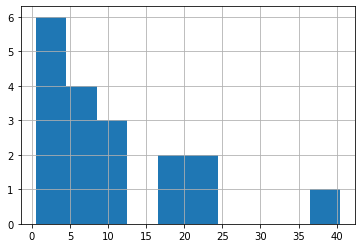

In [26]:
df[(df['Primary_Pos']==tier_pos) & (df['z']>0)]['Value'].hist()

### StatCast work

In [27]:
sc = statcast('2019-03-01', '2021-11-30')

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates


100%|██████████| 568/568 [03:56<00:00,  2.40it/s]


In [33]:
sc.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estima

In [43]:
sc[(sc['batter']==645277) & (sc['launch_speed'].notna())]['launch_speed'].sort_values()

1581     12.6
3777     20.0
3629     22.0
2725     25.4
2180     25.8
        ...  
3101    110.3
515     110.8
139     111.3
360     111.4
737     125.3
Name: launch_speed, Length: 2264, dtype: float64

In [38]:
sc.groupby('batter')['launch_speed'].max().sort_values(ascending=False).head(45)

batter
645277    125.3
519317    122.2
596146    120.0
665489    119.7
592518    119.6
572287    119.4
553993    119.3
596142    119.1
592450    119.0
660271    119.0
443558    118.8
614173    118.6
624413    118.4
606157    118.3
665833    118.2
656467    118.0
594953    118.0
547989    117.9
543807    117.9
660670    117.9
592885    117.9
670541    117.9
624585    117.9
673357    117.7
606213    117.7
656941    117.6
608336    117.6
543760    117.5
642133    117.4
646240    117.4
543068    117.2
593934    117.1
570731    117.1
541645    116.7
595879    116.7
665487    116.6
665742    116.6
545361    116.6
405395    116.6
457708    116.5
621043    116.4
547180    116.4
592669    116.4
606466    116.3
605196    116.2
Name: launch_speed, dtype: float64

In [54]:
sc = pd.read_csv('data/statcast-exit_velocity.csv')
sc = sc.sort_values('brl_pa', ascending=False)
sc = sc.merge(df[['playerid', 'Name', 'Primary_Pos']], on='playerid', how='left')
sc.Name.fillna(sc['first_name']+' '+sc['last_name'],inplace=True)
sc = sc[~sc['Primary_Pos'].isin(['SP', 'RP'])]
sc['brl_pa_rank'] = sc.brl_pa.rank(pct=True)

In [60]:
sc['brl_pa_rank'] = sc.brl_pa.rank(pct=True)

In [69]:
sc.loc[850]

last_name                      Tauchman
first_name                         Mike
playerid                          15274
player_id                        643565
year                               2019
attempts                            190
avg_hit_angle                      11.3
anglesweetspotpercent              39.5
max_hit_speed                     109.8
avg_hit_speed                      88.7
fbld                               91.4
gb                                 87.7
max_distance                        413
avg_distance                        181
avg_hr_distance                     381
ev95plus                             74
ev95per-swing                      13.4
ev95percent                        38.9
barrels                              12
brl_percent                         6.3
brl_pa                              4.1
Name                      Mike Tauchman
Primary_Pos                         NaN
brl_pa_rank                    0.442698
Name: 850, dtype: object

In [55]:
pd.pivot_table(columns='year', data=sc, index='Name')

anglesweetspotpercent             attempts                \
year                                 2019  2020  2021     2019   2020   2021   
Name                                                                           
 Abraham Almonte                      NaN   NaN  32.4      NaN    NaN  111.0   
 Adam Jones                          31.3   NaN   NaN    387.0    NaN    NaN   
 Addison Russell                     33.1   NaN   NaN    160.0    NaN    NaN   
 Adeiny Hechavarría                  30.8  21.3   NaN    156.0   47.0    NaN   
 Akil Baddoo                          NaN   NaN  37.4      NaN    NaN  294.0   
...                                   ...   ...   ...      ...    ...    ...   
Yordan Alvarez                       39.4   NaN  37.2    221.0    NaN  395.0   
Yoshi Tsutsugo                        NaN  25.0  28.8      NaN  108.0  160.0   
Yu Chang                             25.5   NaN  37.9     51.0    NaN  169.0   
Yuli Gurriel                         33.5  34.4  31.0    505.0  189.0  474.0   
Zack Collins                         42.6   NaN  40.9     47.0    NaN  127.0   

                    avg_distance               avg_hit_angle              \
year                        2019   2020   2021          2019  2020  2021   
Name                                                                       
 Abraham Almonte             NaN    NaN  163.0           NaN   NaN  10.5   
 Adam Jones                168.0    NaN    NaN          13.5   NaN   NaN   
 Addison Russell           166.0    NaN    NaN           9.1   NaN   NaN   
 Adeiny Hechavarría        175.0  140.0    NaN          11.8  11.2   NaN   
 Akil Baddoo                 NaN    NaN  175.0           NaN   NaN  13.8   
...                          ...    ...    ...           ...   ...   ...   
Yordan Alvarez             203.0    NaN  194.0          13.4   NaN  14.1   
Yoshi Tsutsugo               NaN  172.0  176.0           NaN  17.2  17.1   
Yu Chang                   162.0    NaN  179.0           9.9   NaN  19.1   
Yuli Gurriel               175.0  183.0  163.0          14.3  13.9  13.4   
Zack Collins               240.0    NaN  200.0          15.3   NaN  20.9   

                    avg_hit_speed             avg_hr_distance                \
year                         2019  2020  2021            2019   2020   2021   
Name                                                                          
 Abraham Almonte              NaN   NaN  89.3             NaN    NaN  382.0   
 Adam Jones                  86.2   NaN   NaN           405.0    NaN    NaN   
 Addison Russell             86.9   NaN   NaN           395.0    NaN    NaN   
 Adeiny Hechavarría          87.6  82.9   NaN           386.0    NaN    NaN   
 Akil Baddoo                  NaN   NaN  86.0             NaN    NaN  385.0   
...                           ...   ...   ...             ...    ...    ...   
Yordan Alvarez               92.2   NaN  93.2           410.0    NaN  408.0   
Yoshi Tsutsugo                NaN  90.2  89.6             NaN  395.0  401.0   
Yu Chang                     87.9   NaN  87.1           432.0    NaN  392.0   
Yuli Gurriel                 89.3  89.3  89.8           384.0  394.0  384.0   
Zack Collins                 90.7   NaN  91.1           413.0    NaN  405.0   

                    barrels             brl_pa            brl_percent       \
year                   2019  2020  2021   2019 2020  2021        2019 2020   
Name                                                                         
 Abraham Almonte        NaN   NaN   8.0    NaN  NaN   4.6         NaN  NaN   
 Adam Jones            26.0   NaN   NaN    4.9  NaN   NaN         6.7  NaN   
 Addison Russell       11.0   NaN   NaN    4.6  NaN   NaN         6.9  NaN   
 Adeiny Hechavarría     9.0   NaN   NaN    4.1  0.0   NaN         5.8  0.0   
 Akil Baddoo            NaN   NaN  26.0    NaN  NaN   5.6         NaN  NaN   
...                     ...   ...   ...    ...  ...   ...         ...  ...   
Yordan Alvarez         37

## ------ End of New Work

In [53]:
from sqlalchemy import text
pid = '19755'
price = 14
owner = 'Wu-Tang'
timestamp = None
t = text("UPDATE players SET Owner='"+owner+"', Paid="+str(price)+" WHERE playerid='"+pid+"'")
#t = text("UPDATE players SET Owner=null, Paid=null, Timestamp=null WHERE playerid='"+pid+"'")
#'Timestamp', 'Paid', 'Owner'
result = conn.execute(t)
result

In [60]:
a = pd.read_sql('players', conn)
mask = a['Owner'].notna()
a[mask][['playerid', 'Name', 'Owner', 'Paid', 'Timestamp']]['Timestamp'].tolist()

['2022-02-27 07:09:59.145405',
 '2022-02-27 07:09:28.384234',
 '2022-02-27 07:01:34.116844',
 '2022-02-27 07:07:11.641207',
 '2022-02-27 07:12:16.239997',
 '2022-03-02 15:48:55.733428',
 '2022-02-27 07:59:40.026471',
 '2022-02-28 07:17:04.647694',
 '2022-02-27 07:06:28.000562',
 '2022-02-27 07:02:07.907164',
 '2022-02-28 10:16:39.029465',
 '2022-02-27 07:15:12.193487',
 '2022-02-27 07:03:43.262593',
 '2022-02-27 07:40:09.735986',
 '2022-02-27 07:30:25.548321',
 '2022-02-27 07:08:05.182137',
 '2022-02-27 07:11:04.955992',
 '2022-03-02 15:45:36.137929',
 '2022-02-27 07:42:14.631676',
 '2022-02-28 10:16:48.553799',
 '2022-03-02 15:46:52.320574',
 '2022-02-28 10:16:26.416598',
 '2022-02-27 07:07:37.505073',
 '2022-02-27 07:15:39.602230',
 '2022-02-28 07:19:21.751439',
 '2022-02-27 07:05:58.803921',
 '2022-02-27 07:23:22.063716',
 '2022-02-28 07:19:00.770854',
 '2022-03-02 15:45:04.163394',
 '2022-03-02 15:47:02.284028',
 '2022-02-27 10:44:44.687985',
 '2022-02-27 07:05:29.642255',
 '2022-0

In [59]:
# Keepers 2021
keepers = {
    'playerid':['19709', '19611', '19755', '19612', '11579', '5361', '18345', '7304', '15711', '18360', '17929', '12161', '18607', '23667', 'sa3011225', '19326', '12546', '13590', '17982',
                 '15429', '15986', '19918', '19287', '22168', '17907', '13757', '5343', '10556', '13265', '16909', '3137', '13125', '10310', '4676', '13743', '14309', '21032', '14765', '18679',
                 '16122', '17282', '26410', '14993', '2233', '11762'],
    'Owner':['Lima Time', 'Harvey', 'Wu-Tang', 'Roid Ragers', 'Charmer', 'Midnight', 'Lima Time', 'Dirty Birds', 'Avg Joes', 'Wu-Tang', 'Lil Trump', 'Trouble', 'Brewbirds', 'Trouble', 'Lima Time',
              'Roid Ragers', 'Charmer', 'Moms Cookin', 'Avg Joes', 'Lil Trump', 'Harvey', 'Lil Trump', 'Roid Ragers', 'Trouble', 'Dirty Birds', 'Avg Joes', 'Lima Time', 'Dirty Birds', 'Moms Cookin',
              'Harvey', 'Harvey', 'Avg Joes', 'Trouble', 'Brewbirds', 'Dirty Birds', 'Moms Cookin', 'Charmer', 'Midnight', 'Wu-Tang', 'Brewbirds', 'Moms Cookin', 'Wu-Tang', 'Charmer', 'Midnight', 
             'Brewbirds'],
    'Paid':[36, 23, 14, 26, 33, 31, 21, 8, 9, 1, 15, 19, 1, 0, 0, 5, 5, 1, 0, 10, 6, 2, 1, 1, 4, 1, 3, 0, 1, 0, 29, 38, 18, 12, 15, 5, 0, 11, 0, 6, 0, 7, 3, 2, 0],
    'Timestamp':['2022-02-28 08:00:00.0', '2022-02-28 08:00:00.0', '2022-02-28 08:00:00.0', '2022-02-28 08:00:00.0', '2022-02-28 08:00:00.0', '2022-02-28 08:00:00.0', '2022-02-28 08:00:00.0',
                '2022-02-28 08:00:00.0', '2022-02-28 08:00:00.0', '2022-02-28 08:00:00.0', '2022-02-28 08:00:00.0', '2022-02-28 08:00:00.0', '2022-02-28 08:00:00.0', '2022-02-28 08:00:00.0',
                '2022-02-28 08:00:00.0', '2022-02-28 08:00:00.0', '2022-02-28 08:00:00.0', '2022-02-28 08:00:00.0', '2022-02-28 08:00:00.0', '2022-02-28 08:00:00.0', '2022-02-28 08:00:00.0',
                '2022-02-28 08:00:00.0', '2022-02-28 08:00:00.0', '2022-02-28 08:00:00.0', '2022-02-28 08:00:00.0', '2022-02-28 08:00:00.0', '2022-02-28 08:00:00.0', '2022-02-28 08:00:00.0',
                '2022-02-28 08:00:00.0', '2022-02-28 08:00:00.0', '2022-02-28 08:00:00.0', '2022-02-28 08:00:00.0', '2022-02-28 08:00:00.0', '2022-02-28 08:00:00.0', '2022-02-28 08:00:00.0',
                '2022-02-28 08:00:00.0', '2022-02-28 08:00:00.0', '2022-02-28 08:00:00.0', '2022-02-28 08:00:00.0', '2022-02-28 08:00:00.0', '2022-02-28 08:00:00.0', '2022-02-28 08:00:00.0',
                '2022-02-28 08:00:00.0', '2022-02-28 08:00:00.0', '2022-02-28 08:00:00.0']
}
pd.DataFrame(keepers)

,playerid,Owner,Paid,Timestamp
0,19709,Lima Time,36,2022-02-28 08:00:00.0
1,19611,Harvey,23,2022-02-28 08:00:00.0
2,19755,Wu-Tang,14,2022-02-28 08:00:00.0
3,19612,Roid Ragers,26,2022-02-28 08:00:00.0
4,11579,Charmer,33,2022-02-28 08:00:00.0
5,5361,Midnight,31,2022-02-28 08:00:00.0
6,18345,Lima Time,21,2022-02-28 08:00:00.0
7,7304,Dirty Birds,8,2022-02-28 08:00:00.0
8,15711,Avg Joes,9,2022-02-28 08:00:00.0
9,18360,Wu-Tang,1,2022-02-28 08:00:00.0


https://leportella.com/sqlalchemy-tutorial/

In [ ]:
#Creates a table on the DB
meta = MetaData()
hitters = Table('hitting', meta,
                Column('playerid', String, primary_key=True),
                #Column('name', String(50)),
                #Column('team', String(20)),
                #Column('pa', Integer),
                #Column('ab', Integer),
                #Column('ba', Float),
                #Column('h', Integer),
                #Column('hr', Integer),
                #Column('r', Integer),
                #Column('rbi', Integer),
                #Column('sb', Integer),
                Column('Paid', Integer),
                Column('Owner', String(25)),
                Column('Used', Boolean)
)
meta.create_all(engine)

In [18]:
conn = engine.connect()

In [20]:
pd.read_sql('hitting', conn)

,index,Name,Team,G,PA,AB,H,2B,3B,HR,R,RBI,BB,SO,HBP,SB,AVG,OBP,SLG,OPS,WAR,playerid,sorter,Pos,Dollars,Primary_Pos,Used,BA,zPA,zAB,zBA,zHR,zRBI,zR,zSB,z,Value,Owner,Paid,Timestamp,IP,HA,GS,ER,Sv,HLD,Sv+Hld,W,ERA,WHIP
0,3,Vladimir Guerrero Jr.,TOR,154,665,575,178,31,2,44,109,122,77,102,6,4,0.309,0.394,0.598,0.992,6.0,19611,457,"1B, DH",40.252202,1B,True,33.335606,0.469136,0.066225,2.389664,1.854545,2.071429,2.022727,0.476190,14.063823,54.473907,None,None,2022-01-13 19:56:12.110798,NaN,None,None,None,None,None,None,None,NaN,NaN
1,1,Fernando Tatis Jr.,SDP,151,651,564,158,30,2,44,112,103,72,161,7,25,0.281,0.366,0.575,0.941,6.7,19709,442,"SS, OF",40.784208,OF,True,17.161705,1.085635,0.795666,1.153108,2.100000,1.459854,2.669643,2.208333,13.641913,52.839708,None,None,2022-01-13 19:56:29.806066,NaN,None,None,None,None,None,None,None,NaN,NaN
2,0,Juan Soto,WSN,154,665,519,161,29,2,37,112,106,135,96,5,12,0.310,0.453,0.586,1.039,7.2,20123,428,OF,37.932103,OF,True,31.398803,1.472376,-0.597523,2.548902,1.225000,1.678832,2.669643,0.402778,12.576129,48.711571,None,None,2022-01-13 19:57:48.386218,NaN,None,None,None,None,None,None,None,NaN,NaN
3,13,Rafael Devers,BOS,154,665,593,165,37,2,37,97,108,58,136,7,6,0.278,0.346,0.534,0.880,4.8,17350,413,3B,27.907182,3B,True,16.010347,0.900344,1.043333,0.901833,1.260274,1.455882,1.447368,-0.278689,7.643909,29.607424,None,None,2022-01-13 20:00:09.607022,NaN,None,None,None,None,None,None,None,NaN,NaN
4,17,Bo Bichette,TOR,152,658,601,176,36,2,28,96,94,43,121,6,17,0.292,0.343,0.496,0.839,4.7,19612,411,"SS, DH",28.080286,SS,True,22.819346,0.762542,1.044218,1.601935,0.900000,1.367089,1.632911,0.900000,11.621147,45.012602,None,None,2022-01-13 20:01:42.395693,NaN,None,None,None,None,None,None,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,585,Jacob Amaya,LAD,2,7,6,1,0,0,0,1,1,1,2,0,0,0.228,0.291,0.368,0.659,0.0,sa3005081,3,SS,-34.996832,SS,False,-0.600818,-21.010033,-19.193878,-0.740082,-6.100000,-10.405063,-10.392405,-1.528571,-29.166122,-112.970179,None,None,NaT,NaN,None,None,None,None,None,None,None,NaN,NaN
624,569,Andy Young,ARI,2,7,6,1,0,0,0,1,1,0,2,0,0,0.221,0.291,0.399,0.690,0.0,19521,3,2B,-35.270584,2B,False,-0.617596,-38.389222,-28.686869,-0.922454,-4.921569,-9.728395,-9.911111,-1.594937,-27.078466,-104.883986,None,None,NaT,NaN,None,None,None,None,None,None,None,NaN,NaN
625,564,Brett Sullivan,MIL,2,6,6,1,0,0,0,1,1,0,1,0,0,0.231,0.285,0.358,0.643,0.0,sa857232,3,C,-25.916788,C,False,-0.499706,-7.479624,-6.920792,-1.166612,-3.433333,-4.615942,-5.772277,-1.107143,-16.095308,-62.342529,None,None,NaT,NaN,None,None,None,None,None,None,None,NaN,NaN
626,563,Chadwick Tromp,ATL,2,6,6,1,0,0,0,1,1,0,2,0,0,0.225,0.275,0.367,0.641,0.0,16953,3,C,-25.916788,C,False,-0.499706,-7.479624,-6.920792,-1.166612,-3.433333,-4.615942,-5.772277,-1.107143,-16.095308,-62.342529,None,None,NaT,NaN,None,None,None,None,None,None,None,NaN,NaN


In [ ]:
#conn.execute(hitters.delete().where(hitters.c.Used==None))

In [ ]:
conn.execute(hitters.update().values(Paid=15, Owner='Harvey').where(hitters.c.playerid=='15172'))
conn.execute(hitters.update().values(Paid=1, Owner='Harvey').where(hitters.c.playerid=='16375'))

In [ ]:
import json
j = h.sort_values('z', ascending=False).to_json(orient='records')
j = json.loads(j)
j

In [34]:
mask = (df['Owner'].isna()) & (df['Primary_Pos']=='OF')
df[mask][['Name', 'z', 'Dollars', 'Pos']].sort_values('z', ascending=False).head(10)

,Name,z,Dollars,Pos
2,Juan Soto,9.390390,37.932103,OF
10,Ronald Acuna Jr.,8.211041,26.025719,OF
9,Bryce Harper,7.248026,27.485023,OF
12,Mike Trout,6.234178,25.942635,OF
16,Yordan Alvarez,6.159642,25.272377,OF/DH
14,Kyle Tucker,6.153412,25.381511,OF
15,Luis Robert,6.083746,25.322911,OF
27,George Springer,5.212707,20.240662,OF/DH
52,Starling Marte,4.995739,14.836125,OF
23,Tyler O'Neill,4.945308,21.173880,OF


In [35]:
single_player = (h['Name']=='Robert Witt')

fig = go.Figure(data=go.Scatterpolar(
  r=h[single_player][['zBA', 'zR', 'zRBI', 'zHR', 'zSB']].values.tolist()[0],
  theta=['zBA', 'zR', 'zRBI', 'zHR', 'zSB'],
  fill='toself',
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True
    ),
  ),
  showlegend=False
)

fig.show()

In [36]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=owners_df['Owner'],
        y=owners_df['Pts'],
    )
)
fig.show()

In [38]:
fig = px.scatter(
    owners_df, x='$ Left', y='Pts', opacity=0.65,
    trendline='ols', trendline_color_override='darkblue'
)
fig.show()

In [23]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats.stats import pearsonr
def scale_data(df, cols):
    """
    INPUT: 
        df: original dataframe
        list: subset of columns to scale
    OUTPUT:
        df: scaled data
    """
    scaler = MinMaxScaler()
    scaler.fit(df[cols])
    scaled_df = scaler.transform(df[cols])
    scaled_df = pd.DataFrame(scaled_df, index=df.index)
    scaled_df.columns=[df[cols].columns.tolist()]
    return scaled_df

In [24]:
cols = ['BA', 'R', 'RBI', 'HR', 'SB']
scaled_df = scale_data(df[df['Owner'].isna()].set_index('playerid'), cols)
scaled_df.loc['11737', cols]

BA     0.814794
R      0.794643
RBI    0.845455
HR     0.707317
SB     0.071429
Name: 11737, dtype: float64

In [25]:
def add_distance_metrics(h, player_id, col_list):
    scaled_df = scale_data(h[h['Owner'].isna()].set_index('playerid'), col_list)
    df2 = h[h['Owner'].isna()].loc[:,['playerid', 'Name', 'Pos', 'z']+col_list].set_index('playerid')
    for j, row in scaled_df.iterrows():
        #df2.at[j,'corr'] = pearsonr(scaled_df.loc[player_id,col_list],row[col_list])[0]
        df2.at[j,'eucl_dist'] = np.linalg.norm(scaled_df.loc[player_id,col_list] - row[col_list])
        #df2.at[j,'manh_dist']= sum(abs(e - s) for s, e in zip(scaled_df.loc[player_id,col_list], row[col_list]))
    return df2.sort_values('eucl_dist').iloc[1:6]

In [29]:
add_distance_metrics(df, '9218', cols)

,Name,Pos,z,BA,R,RBI,HR,SB,eucl_dist
playerid,,,,,,,,,
5361,Freddie Freeman,1B,4.859708,0.292442,103.0,95.0,30.0,6.0,0.089777
11737,Nick Castellanos,OF,4.280219,0.271598,89.0,93.0,29.0,3.0,0.125117
18882,Brandon Lowe,2B/OF,3.450559,0.247494,88.0,87.0,32.0,6.0,0.131340
12856,George Springer,OF/DH,5.212707,0.259904,100.0,88.0,35.0,7.0,0.134661
11493,Manny Machado,3B,4.483346,0.273769,92.0,102.0,32.0,10.0,0.146305


In [ ]:
mask = (df['Pos'].str.contains('C')) & (df['Owner'].isna())
df[mask][['Name', 'z', 'Dollars', 'HR', 'R', 'RBI', 'SB', 'BA']].sort_values('z', ascending=False).head(10)

In [15]:
# (Tm 1 $/plyr left / Tm 2 $/plyr left) * suggested price = equivalent comfort level
pp = 5
f'If the price is {pp}, Tm 1 can afford to pay up to {round((10.125 / 6.9) * pp,1)} at the same comfort level as Tm 2'

'If the price is 5, Tm 1 can afford to pay up to 7.3 at the same comfort level as Tm 2'

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=b['Dollars'],
    y=b['Value'],
    mode='markers',
    text=b['Name']
)
)
fig.show()

In [ ]:
#Creates a table on the DB
meta = MetaData()
players = Table('players', meta,
                Column('playerid', String, primary_key=True),
                Column('Name', String(50)),
                Column('Team', String(20)),
                Column('Pos', String(30)),
                Column('Primary_Pos', String(10)),
                Column('G', Integer),
                Column('GS', Integer),
                Column('PA', Integer),
                Column('AB', Integer),
                Column('H', Integer),
                Column('HR', Integer),
                Column('R', Integer),
                Column('RBI', Integer),
                Column('SB', Integer),
                Column('BA', Float),
                Column('OBP', Float),
                Column('SLG', Float),
                Column('OPS', Float),
                Column('IP', Float),
                Column('Outs', Integer),
                Column('HA', Integer),
                Column('BB', Integer),
                Column('ER', Integer),
                Column('SV', Integer),
                Column('HLD', Integer),
                Column('Sv+Hld', Integer),
                Column('W', Integer),
                Column('SO', Integer),
                Column('ERA', Float),
                Column('WHIP', Float),
                Column('K/9', Float),
                Column('Dollars', Float),
                Column('z', Float),
                Column('Value', Float),
                Column('Paid', Integer),
                Column('Owner', String(25)),
                Column('Used', Boolean),
                Column('Timestamp', DateTime)
)
meta.create_all(engine)

In [ ]:
conn.execute('ALTER TABLE hitting ADD COLUMN WHIP Float')

In [ ]:
#conn.execute('DROP Table players')

In [ ]:
#conn.execute('ALTER TABLE hitting DROP COLUMN Paid2')

In [ ]:
#conn.execute('ALTER TABLE hitting ADD COLUMN Timestamp DATETIME')

In [ ]:
conn.close()